# Introduction

In this basic notebook we'll do some easy data visualizations and feature engineering before applying different machine learning algorithms like Logistic Regression, Random Forest, Support Vector Machines and more. We're also using a PCA and ROC-Curve for better understanding of the dataset/algorithms.

**If you have any suggestions on how to improve this notebook please let me know!**

## Import modules

In [1]:
import numpy as np
import pandas as pd
import missingno

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
from matplotlib.pyplot import plot

style.use("seaborn-whitegrid")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


## Import data

In [2]:
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")

In [3]:
data_size_train = train.memory_usage().sum() / 1024 / 1024
print("Data memory size: %.2f MB" % data_size_train)

Data memory size: 0.08 MB


In [4]:
data_size_test = test.memory_usage().sum() / 1024 / 1024
print("Data memory size: %.2f MB" % data_size_test)

Data memory size: 0.04 MB


## Data exploration

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
print(train.shape)
train.head(3)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [8]:
print(test.shape)
test.head(3)

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


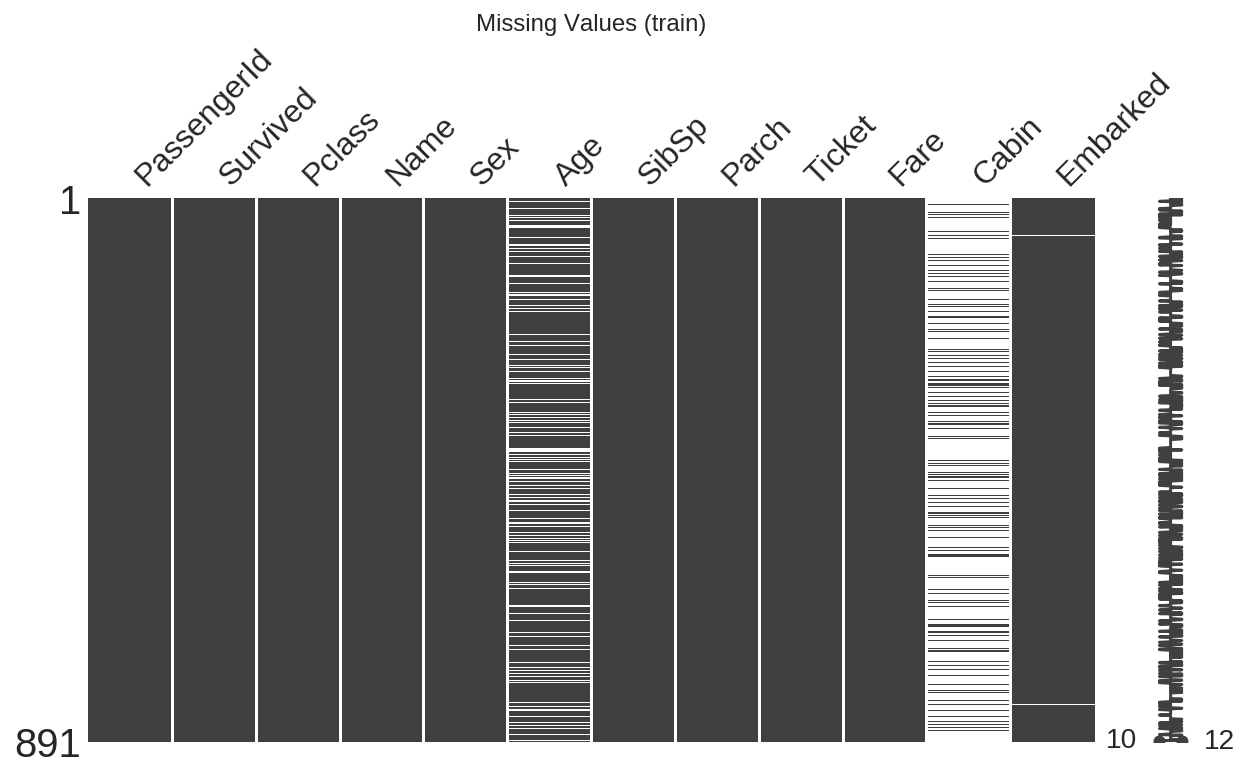

In [9]:
missingno.matrix(train, figsize = (10,5))
plt.title("Missing Values (train)")
plt.show()

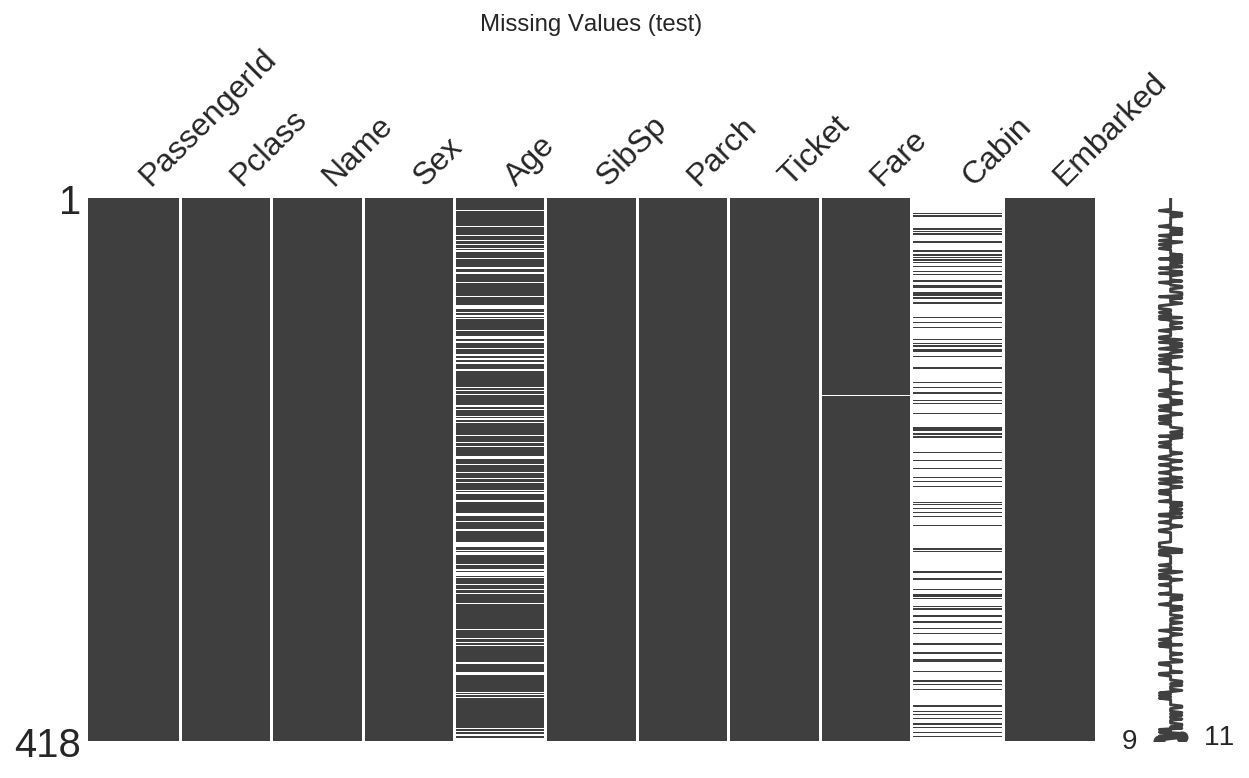

In [10]:
missingno.matrix(test, figsize = (10,5))
plt.title("Missing Values (test)")
plt.show()

In [11]:
train["Embarked"].fillna(train["Embarked"].mode()[0], inplace = True)
train["Age"].fillna(train["Age"].mean(), inplace = True)
train = train.drop(["Cabin", "Ticket"], axis = 1)
print(train.isnull().sum().sort_values(ascending = False).head(3))

print("-------------")

test["Fare"].fillna(test["Fare"].mean(), inplace = True)
test["Age"].fillna(test["Age"].mean(), inplace = True)
test = test.drop(["Cabin", "Ticket"], axis = 1)
print(test.isnull().sum().sort_values(ascending = False).head(3))

Embarked    0
Fare        0
Parch       0
dtype: int64
-------------
Embarked    0
Fare        0
Parch       0
dtype: int64


## Feature engineering

### Name Title

In [12]:
train["NameTitle"] = train["Name"].str.split(", ", expand = True)[1].str.split(". ", expand = True)[0]
test["NameTitle"] = test["Name"].str.split(", ", expand = True)[1].str.split(". ", expand = True)[0]

train = train.drop("Name", axis = 1)
test = test.drop("Name", axis = 1)

print(train["NameTitle"].unique())
print("------------------------" * 3)
print(test["NameTitle"].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'th' 'Jonkheer']
------------------------------------------------------------------------
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


In [13]:
min_titles = (train["NameTitle"].value_counts() < 10)
train["NameTitle"] = train["NameTitle"].apply(lambda x: "Misc" if min_titles.loc[x] == True else x)
print(train["NameTitle"].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Misc']


In [14]:
min_titles = (test["NameTitle"].value_counts() < 10)
test["NameTitle"] = test["NameTitle"].apply(lambda x: "Misc" if min_titles.loc[x] == True else x)
print(test["NameTitle"].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Misc']


### Family Size

In [15]:
train["FamilySize"] = train["SibSp"] + train["Parch"]
test["FamilySize"] = test["SibSp"] + test["Parch"]

### Age Group

In [16]:
train["AgeGroup"] = ""
train.loc[train["Age"] < 21, "AgeGroup"] = "under 21"
train.loc[train["Age"] >= 21, "AgeGroup"] = "21-65"
train.loc[train["Age"] > 65, "AgeGroup"] = "65+"

test["AgeGroup"] = ""
test.loc[test["Age"] < 21, "AgeGroup"] = "under 21"
test.loc[test["Age"] >= 21, "AgeGroup"] = "21-65"
test.loc[test["Age"] > 65, "AgeGroup"] = "65+"

In [17]:
print(train.shape)
train.head(3)

(891, 12)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,NameTitle,FamilySize,AgeGroup
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,1,21-65
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs,1,21-65
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,0,21-65


In [18]:
print(test.shape)
test.head(3)

(418, 11)


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,NameTitle,FamilySize,AgeGroup
0,892,3,male,34.5,0,0,7.8292,Q,Mr,0,21-65
1,893,3,female,47.0,1,0,7.0000,S,Mrs,1,21-65
2,894,2,male,62.0,0,0,9.6875,Q,Mr,0,21-65


## Data visualization

### Survived

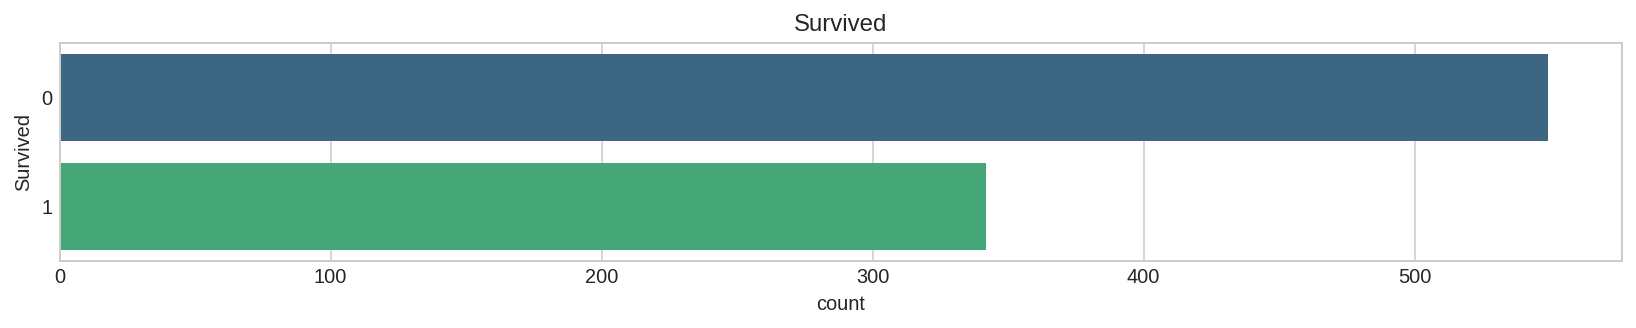

In [19]:
plt.figure(figsize = (14,2))
sns.countplot(data = train, y = "Survived", palette = "viridis")
plt.title("Survived")
plt.show()

### Class

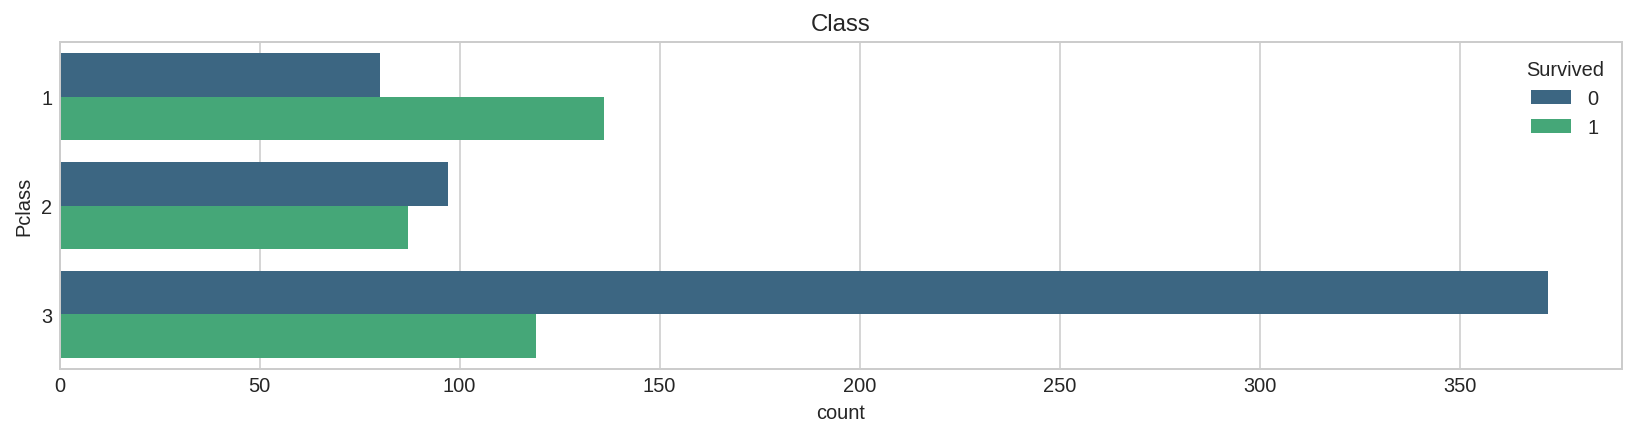

In [20]:
plt.figure(figsize = (14,3))
sns.countplot(data = train, y = "Pclass", hue = "Survived", palette = "viridis")
plt.title("Class")
plt.show()

### Gender

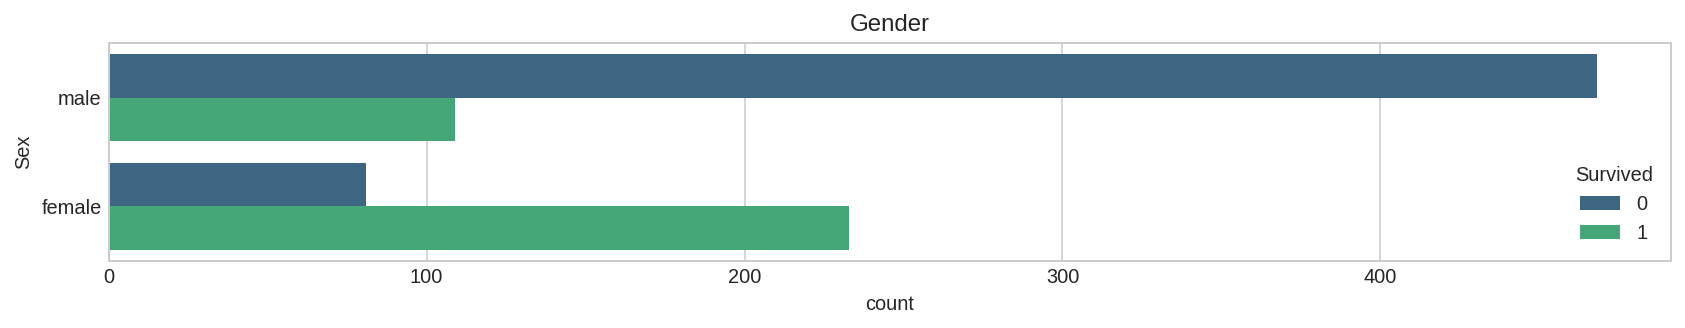

In [21]:
plt.figure(figsize = (14,2))
sns.countplot(data = train, y = "Sex", hue = "Survived", palette = "viridis")
plt.title("Gender")
plt.show()

### Family Size

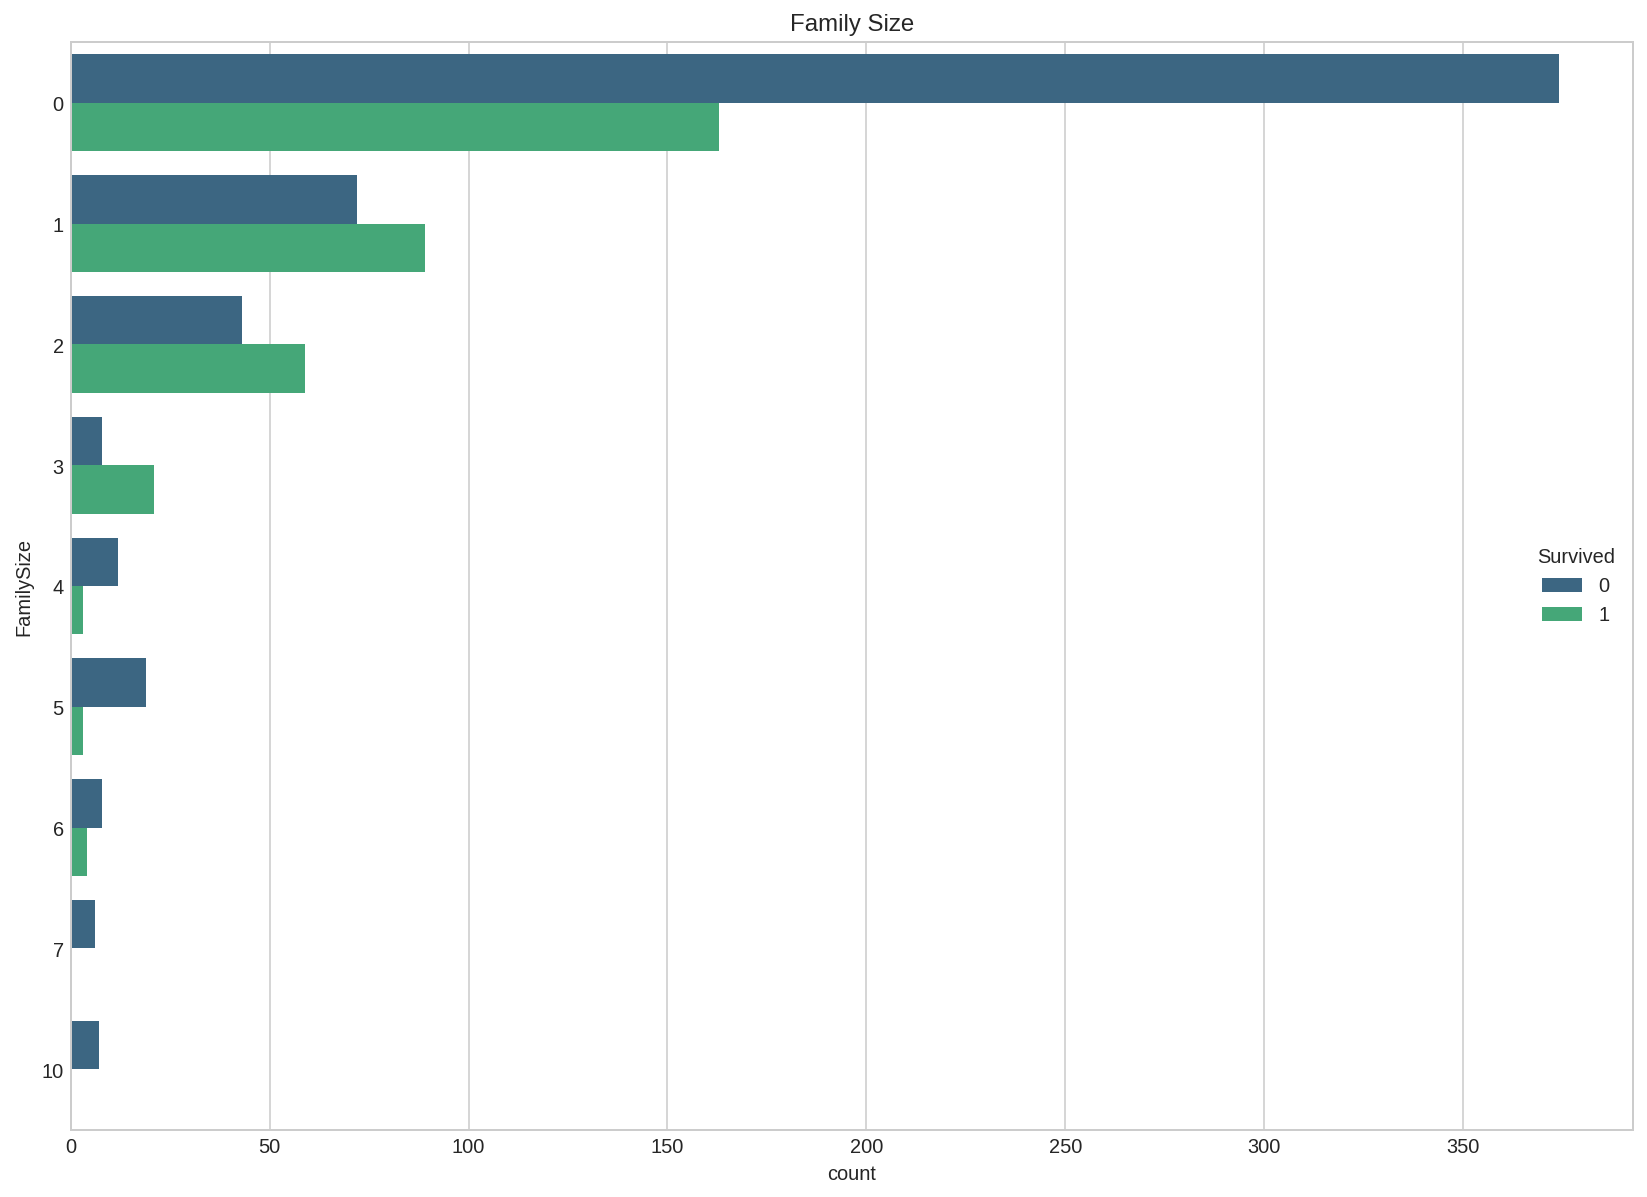

In [22]:
plt.figure(figsize = (14,10))
sns.countplot(data = train, y = "FamilySize", hue = "Survived", palette = "viridis")
plt.title("Family Size")
plt.show()

### Embarked

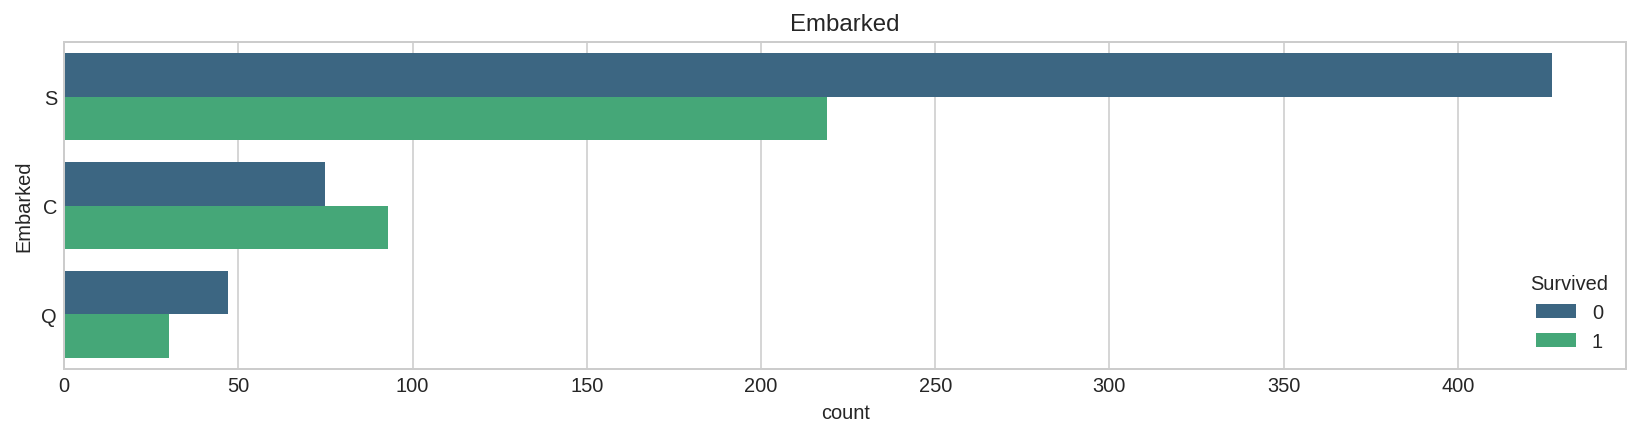

In [23]:
plt.figure(figsize = (14,3))
sns.countplot(data = train, y = "Embarked", hue = "Survived", palette = "viridis")
plt.title("Embarked")
plt.show()

### Name Title

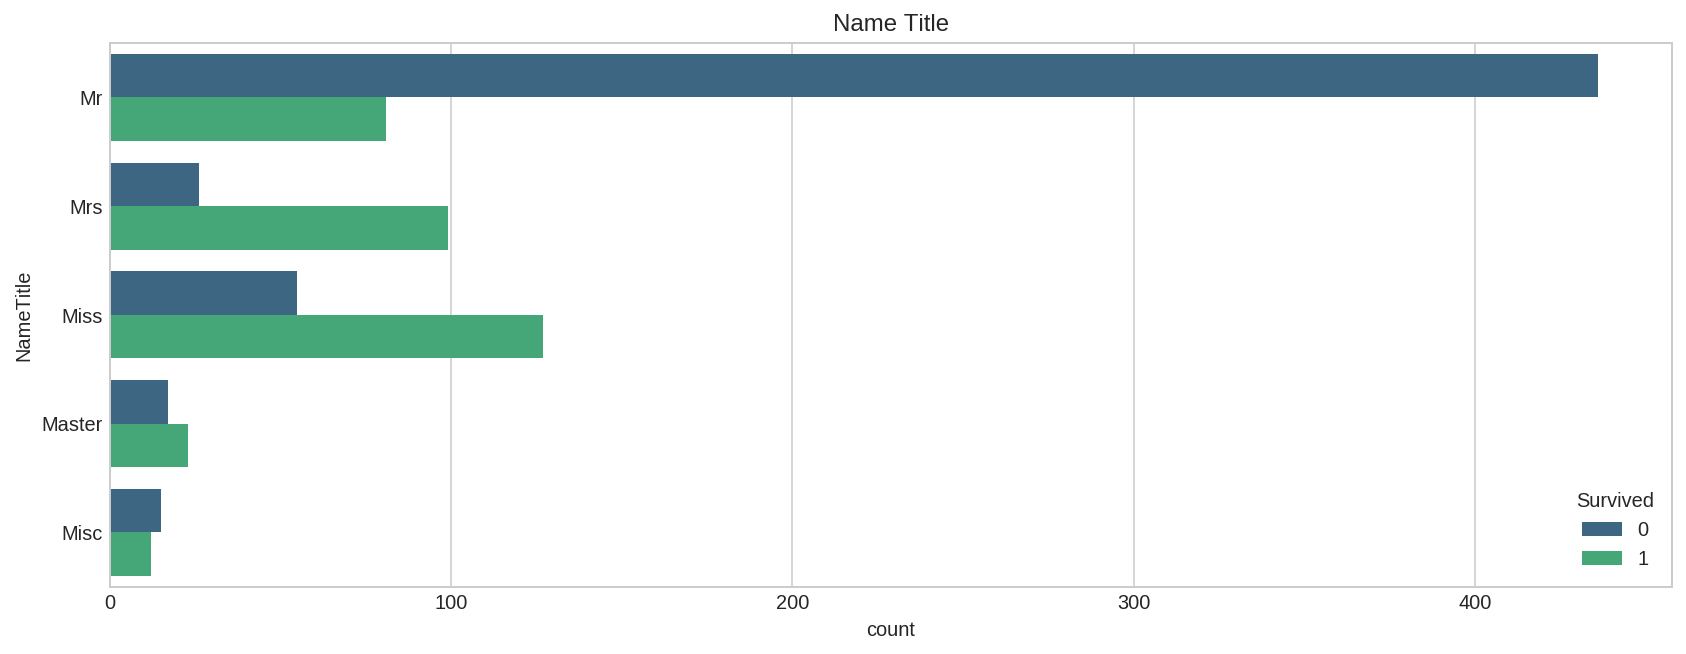

In [24]:
plt.figure(figsize = (14,5))
sns.countplot(data = train, y = "NameTitle", hue = "Survived", palette = "viridis")
plt.title("Name Title")
plt.show()

### Age Group

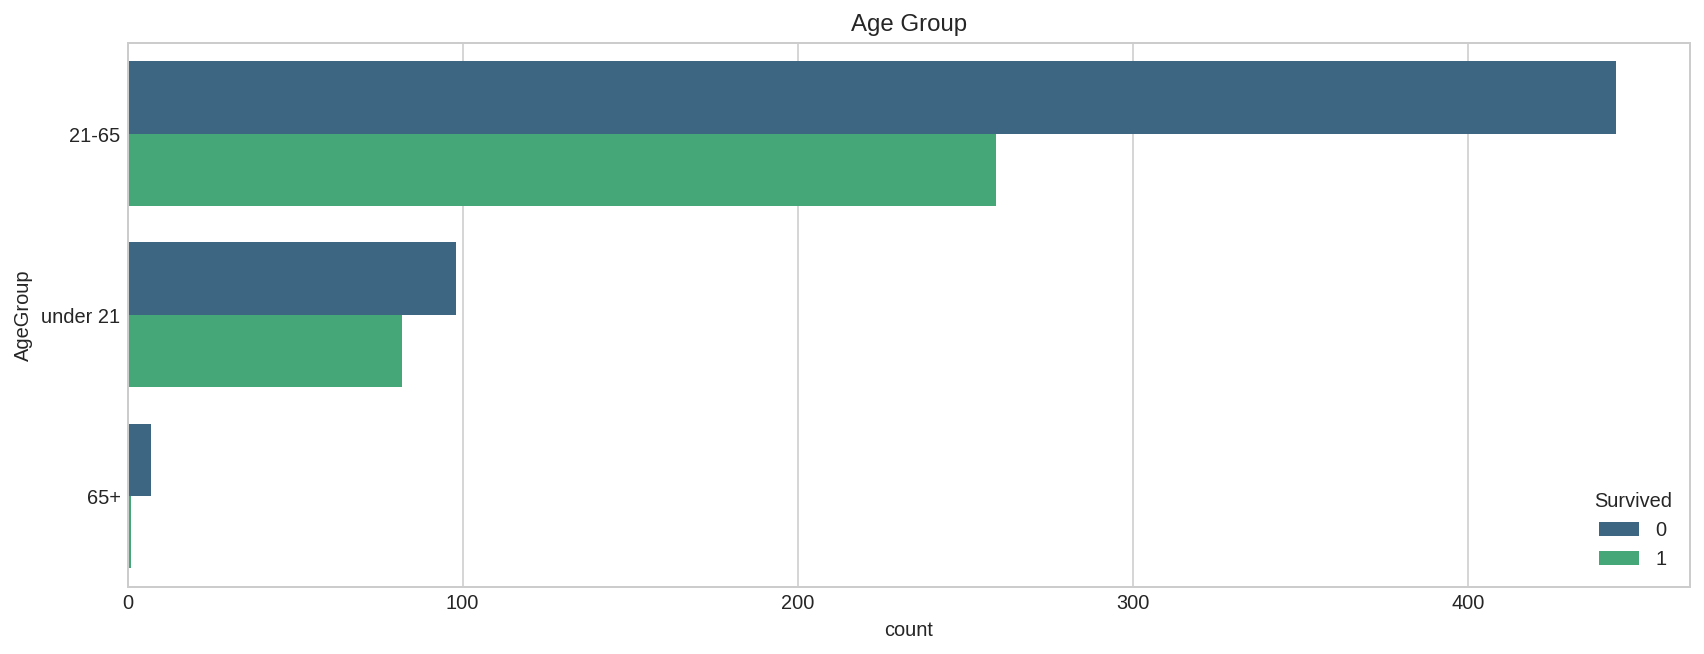

In [25]:
plt.figure(figsize = (14,5))
sns.countplot(data = train, y = "AgeGroup", hue = "Survived", palette = "viridis")
plt.title("Age Group")
plt.show()

### Correlation

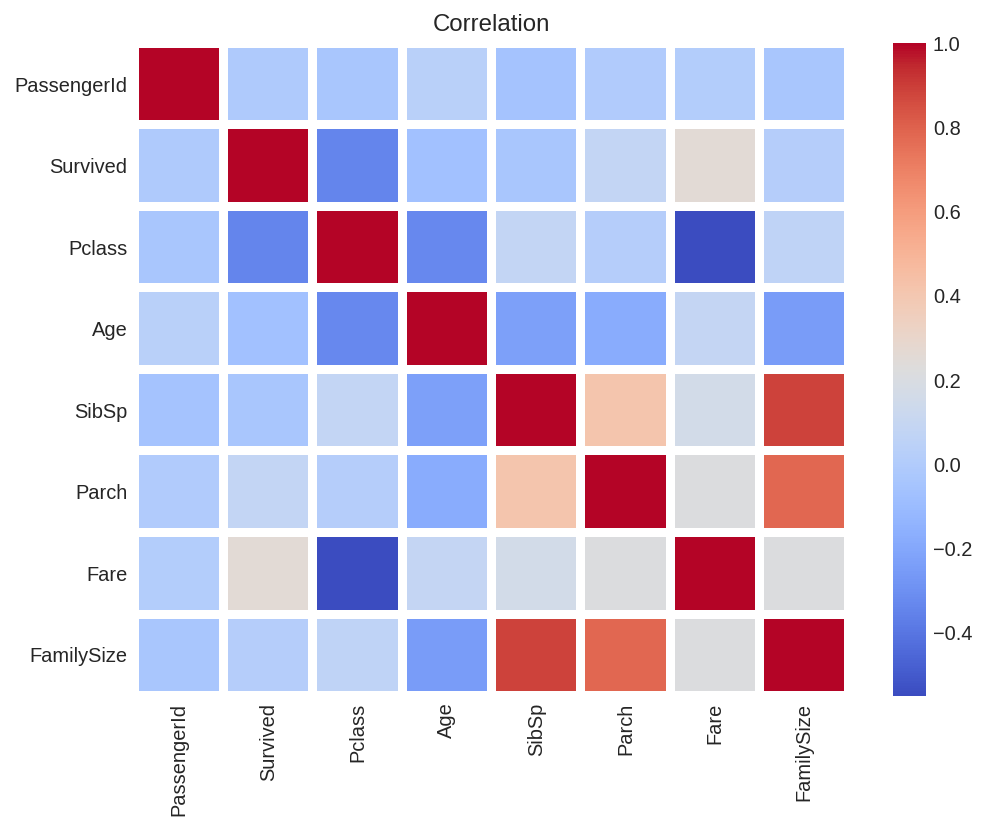

In [26]:
corr = train.corr()
plt.figure(figsize = (8,6))
sns.heatmap(corr, cmap = "coolwarm", linewidth = 4, linecolor = "white")
plt.title("Correlation")
plt.show()

In [27]:
train = train.drop(["SibSp", "Parch"], axis = 1)
test = test.drop(["SibSp", "Parch"], axis = 1)

In [28]:
train = pd.get_dummies(train, columns = ["Sex", "Embarked", "NameTitle", "AgeGroup"])
test = pd.get_dummies(test, columns = ["Sex", "Embarked", "NameTitle", "AgeGroup"])

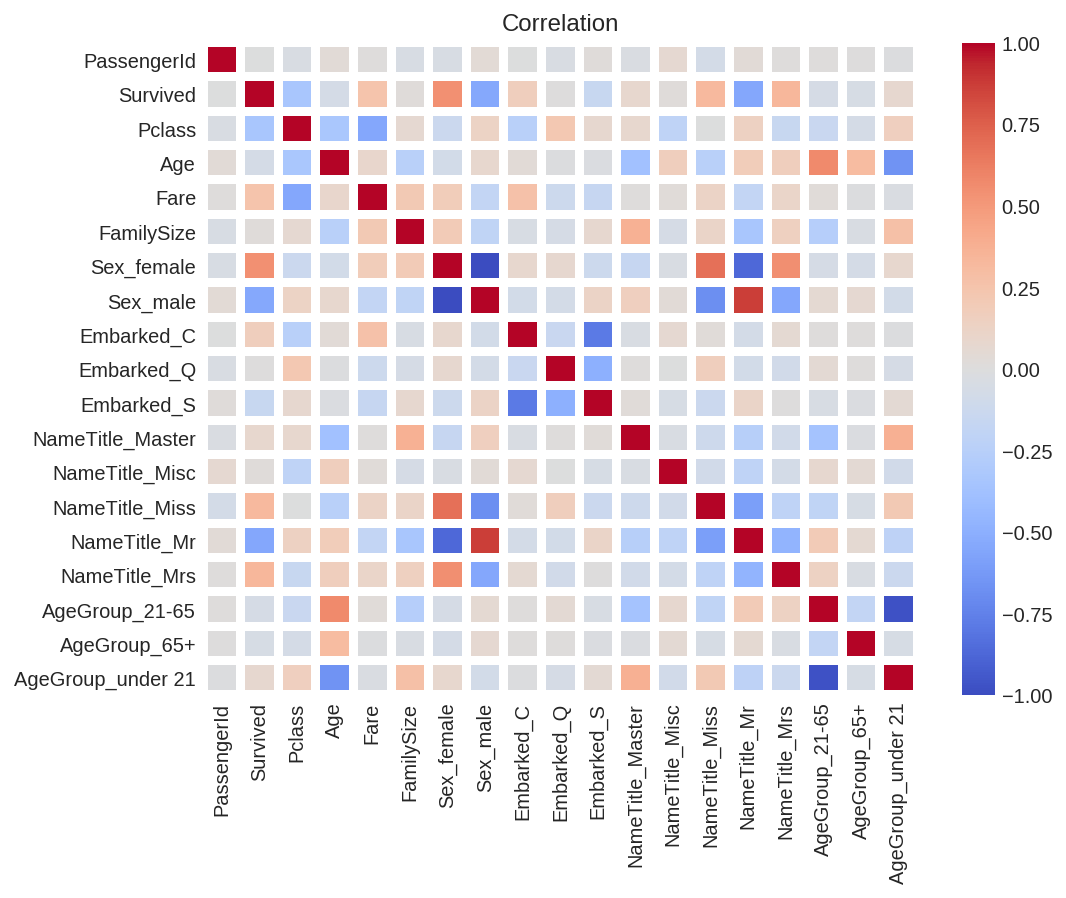

In [29]:
corr = train.corr()
plt.figure(figsize = (8,6))
sns.heatmap(corr, cmap = "coolwarm", linewidth = 4, linecolor = "white")
plt.title("Correlation")
plt.show()

In [30]:
upper = corr.where(np.triu(np.ones(corr.shape), k = 1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
print(to_drop)

[]


## PCA

In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = train.drop(["PassengerId", "Survived"], axis = 1)
Y = train["Survived"]

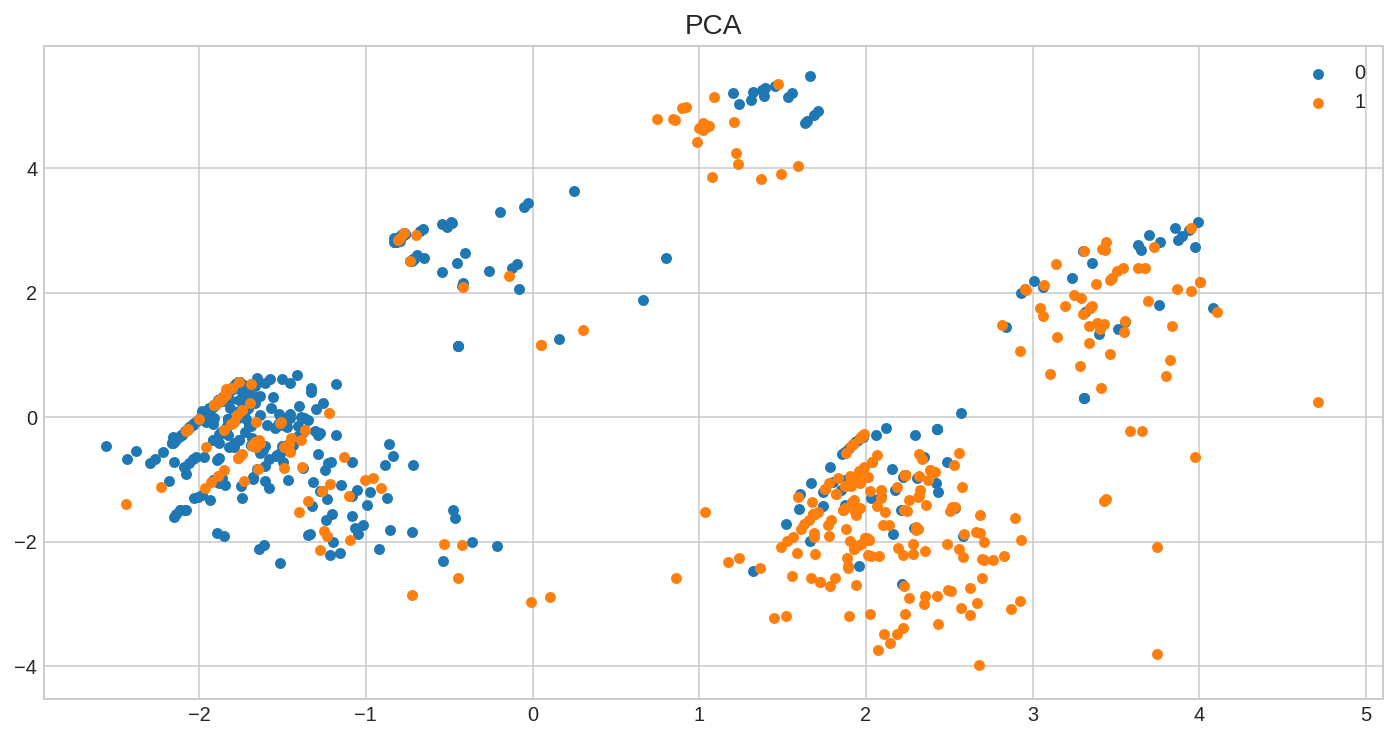

In [32]:
scaler = StandardScaler()
X_pca = scaler.fit_transform(X)

pca = PCA(n_components = 2)
X_pca_transformed = pca.fit_transform(X_pca)

plt.figure(figsize = (12,6))

for i in Y.unique():
    X_pca_filtered = X_pca_transformed[Y == i, :]
    plt.scatter(X_pca_filtered[:, 0], X_pca_filtered[:, 1], s = 20, label = i)
    
plt.legend()
plt.title("PCA", fontsize = 14)
plt.show()

## Machine Learning

In [33]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y, 
                                                    random_state = 0, 
                                                    test_size = 0.25)

### XGBoost

In [35]:
clf_xgb = XGBClassifier()

params = {"n_estimators" : [1000, 2000],
          "learning_rate" : [0.005, 0.1],
          "max_depth" : [3, 5],
          "max_features" : [3, 5], 
          "gamma" : [0.4, 0.5, 0.6]}

gsc_xgb = GridSearchCV(clf_xgb, params, cv = 5) 
gsc_xgb = gsc_xgb.fit(X_train, Y_train)

print(gsc_xgb.best_estimator_)
clf_xgb = gsc_xgb.best_estimator_
clf_xgb.fit(X_train, Y_train)

print("")
print("Test Score: " + str(round(clf_xgb.score(X_test, Y_test), 4)))
print("Train Score: " + str(round(clf_xgb.score(X_train, Y_train), 4)))

Y_predicted_xgb = clf_xgb.predict_proba(X_test)[:, 1]

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.005, max_delta_step=0, max_depth=5,
              max_features=3, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

Test Score: 0.8386
Train Score: 0.9012


### Gradient Boosting

In [36]:
clf_boost = GradientBoostingClassifier()

params = {"n_estimators" : [300, 500, 700],
          "learning_rate" : [0.002, 0.01, 0.05],
          "max_depth" : [3, 5],
          "max_features" : [7, 9]}

gsc_boost = GridSearchCV(clf_boost, params, cv = 5) 
gsc_boost = gsc_boost.fit(X_train, Y_train)

print(gsc_boost.best_estimator_)
clf_boost = gsc_boost.best_estimator_
clf_boost.fit(X_train, Y_train)

print("")
print("Test Score: " + str(round(clf_boost.score(X_test, Y_test), 4)))
print("Train Score: " + str(round(clf_boost.score(X_train, Y_train), 4)))

Y_predicted_boost = clf_boost.predict_proba(X_test)[:, 1]

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.002, loss='deviance', max_depth=5,
                           max_features=9, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=700,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Test Score: 0.8475
Train Score: 0.8802


### Logistic Regression

In [37]:
clf_log = LogisticRegression()

params = {"C" : [0.001, 0.01, 0.1, 1, 1.1, 10],
          "max_iter" : [10000],
          "solver" : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}

gsc_log = GridSearchCV(clf_log, params, cv = 5) 
gsc_log = gsc_log.fit(X_train, Y_train)

print(gsc_log.best_estimator_)
clf_log = gsc_log.best_estimator_
clf_log.fit(X_train, Y_train)

print("")
print("Test Score: " + str(round(clf_log.score(X_test, Y_test), 4)))
print("Train Score: " + str(round(clf_log.score(X_train, Y_train), 4)))

Y_predicted_log = clf_log.predict_proba(X_test)[:, 1]

LogisticRegression(C=1.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Test Score: 0.8251
Train Score: 0.8353


### Random Forest

In [38]:
clf_rf = RandomForestClassifier(criterion = "gini", 
                                max_features = "auto")

params = {"max_depth" : [3, 5, 7],
          "n_estimators" : [500, 700, 1000]}

gsc_rf = GridSearchCV(clf_rf, params, cv = 5) 
gsc_rf = gsc_rf.fit(X_train, Y_train)

print(gsc_rf.best_estimator_)
clf_rf = gsc_rf.best_estimator_
clf_rf.fit(X_train, Y_train)

print("")
print("Test Score: " + str(round(clf_rf.score(X_test, Y_test), 4)))
print("Train Score: " + str(round(clf_rf.score(X_train, Y_train), 4)))

Y_predicted_rf = clf_rf.predict_proba(X_test)[:, 1]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Test Score: 0.8251
Train Score: 0.8443


### SVM

In [39]:
pipeline = Pipeline([("scaler", StandardScaler()), ("svm", SVC(probability = True, kernel = "rbf"))])

params = {"svm__C" : [0.01, 0.1, 1],
          "svm__gamma" : [0.01, 0.1, 1]}

gsc_svm = GridSearchCV(pipeline, param_grid = params, cv = 5) 
gsc_svm = gsc_svm.fit(X_train, Y_train)

print(gsc_svm.best_estimator_)
clf_svm = gsc_svm.best_estimator_
clf_svm.fit(X_train, Y_train)

print("")
print("Test Score: " + str(round(clf_svm.score(X_test, Y_test), 4)))
print("Train Score: " + str(round(clf_svm.score(X_train, Y_train), 4)))

Y_predicted_svm = clf_svm.predict_proba(X_test)[:, 1]

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.1, kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

Test Score: 0.8206
Train Score: 0.8503


## ROC-Curve and AUC-Score

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score

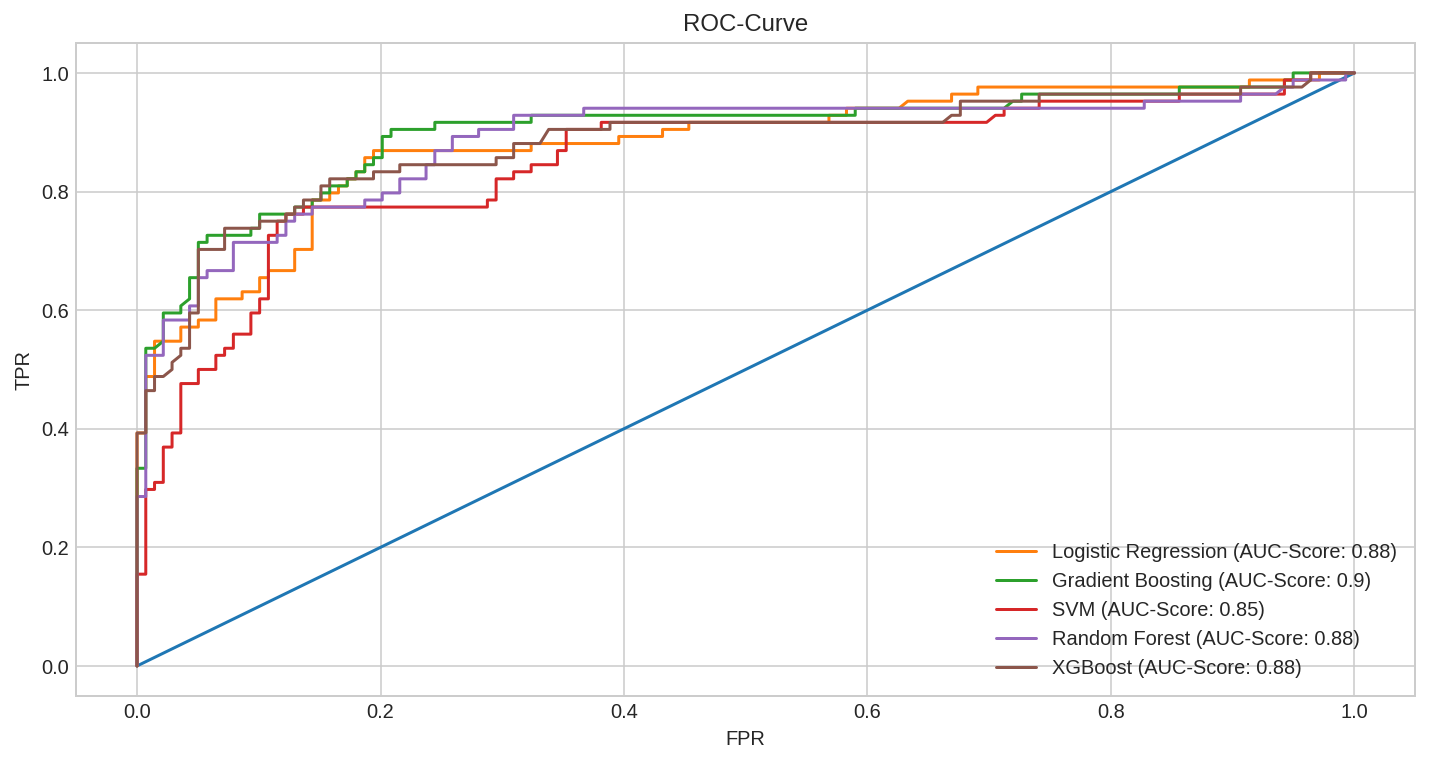

In [41]:
log_fpr, log_tpr, log_treshholds = roc_curve(Y_test, Y_predicted_log)
boost_fpr, boost_tpr, boost_treshholds = roc_curve(Y_test, Y_predicted_boost) 
svm_fpr, svm_tpr, svm_treshholds = roc_curve(Y_test, Y_predicted_svm)
rf_fpr, rf_tpr, rf_treshholds = roc_curve(Y_test, Y_predicted_rf)
xgb_fpr, xgb_tpr, xgb_treshholds = roc_curve(Y_test, Y_predicted_xgb)

auc_score_log = roc_auc_score(Y_test, Y_predicted_log)
auc_score_boost = roc_auc_score(Y_test, Y_predicted_boost)
auc_score_svm = roc_auc_score(Y_test, Y_predicted_svm)
auc_score_rf = roc_auc_score(Y_test, Y_predicted_rf)
auc_score_xgb = roc_auc_score(Y_test, Y_predicted_xgb)

plt.figure(figsize = (12,6))
plt.plot([0,1], [0,1])
plt.plot(log_fpr, log_tpr, label = "Logistic Regression (AUC-Score: " + str(round(auc_score_log, 2)) + ")")
plt.plot(boost_fpr, boost_tpr, label = "Gradient Boosting (AUC-Score: " + str(round(auc_score_boost, 2)) + ")")
plt.plot(svm_fpr, svm_tpr, label = "SVM (AUC-Score: " + str(round(auc_score_svm, 2)) + ")")
plt.plot(rf_fpr, rf_tpr, label = "Random Forest (AUC-Score: " + str(round(auc_score_rf, 2)) + ")")
plt.plot(xgb_fpr, xgb_tpr, label = "XGBoost (AUC-Score: " + str(round(auc_score_xgb, 2)) + ")")
plt.title("ROC-Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

## Voting Classifier Stacking

In [42]:
vote = VotingClassifier(estimators = [("XGBoost", clf_xgb), 
                                      ("GradientBoosting", clf_boost),
                                      ("RandomForest", clf_rf)], 
                                      voting = "hard")

vote.fit(X_train, Y_train)
print(round(vote.score(X_test, Y_test), 4))

Y_predicted_stack = vote.predict(test.drop(["PassengerId"], axis = 1))

0.8341


## Submission

In [43]:
submission = pd.DataFrame({"PassengerId" : test.PassengerId, 
                           "Survived" : Y_predicted_stack})

submission.to_csv("submission_v8.csv", index = False)